In [ ]:
!pip install nlpaug numpy matplotlib python-dotenv --quiet
!pip install fairseq --quiet
!pip install sacremoses --quiet
!pip install fastBPE --quiet

     |████████████████████████████████| 389kB 6.6MB/s 
     |████████████████████████████████| 1.7MB 5.3MB/s 
     |████████████████████████████████| 133kB 22.8MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 112kB 18.0MB/s 
     |████████████████████████████████| 276kB 17.8MB/s 
     |████████████████████████████████| 890kB 7.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import  classification_report, confusion_matrix
from scipy import stats
import random
import nlpaug.augmenter.word as naw
from fairseq.models.transformer import TransformerModel
from sacremoses import MosesTokenizer, MosesDetokenizer
import fastBPE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

%matplotlib inline
import seaborn as sns

sns.set()

# supress warnings (warnings do not prevent the code from executing)
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# check for gpu
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tweets_df = pd.read_csv(r"/content/drive/MyDrive/Data/disaster_tweets.csv.zip (Unzipped Files)/tweets.csv")

tweets_df.info()

tweets_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


## Data Cleaning

We will start by removing the redundant id column.

In [ ]:
tweets_df2 = tweets_df.drop("id", axis=1)
tweets_df2.head()

,keyword,location,text,target
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
tweets_df2.isnull().sum()

keyword        0
location    3418
text           0
target         0
dtype: int64

Since we are most interested in the text and targets columns for our analysis, we won't remove the rows with missing values in the location column because that would reduce our dataset by at least 30% and we only have over 11,000 data points as it is. The location column isn't relevent for our anaylsis anyway. In fact let's drop the column before continuing.

In [ ]:
tweets_df3 = tweets_df2.drop("location", axis=1)
tweets_df3.head()

,keyword,text,target
0,ablaze,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
def text_cleaner(text):
    # remove web links, special characters, and numbers
    text = re.sub(
        r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+
        |(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""",
        "",
        text,
    )
    # make alphanumeric
    text = re.sub("\w*\d\w*", " ", text)
    # lower case and remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), " ", text.lower())
    text = " ".join(text.split())
    return text


def column_cleaner(column):
    temp = []
    for c in column:
        cleaned = text_cleaner(c)
        temp.append(cleaned)

    column = temp
    return column

In [ ]:
tweets_df4 = tweets_df3.copy()
tweets_df4["keyword"] = column_cleaner(tweets_df3["keyword"])
tweets_df4["text"] = column_cleaner(tweets_df3["text"])
tweets_df4.head()

,keyword,text,target
0,ablaze,communal violence in bhainsa telangana stones ...,1
1,ablaze,telangana section has been imposed in bhainsa ...,1
2,ablaze,arsonist sets cars ablaze at dealership,1
3,ablaze,arsonist sets cars ablaze at dealership,1
4,ablaze,lord jesus your love brings freedom and pardon...,0


## Exploratory Data Analysis

Let's first check our target variable and check for class balance.

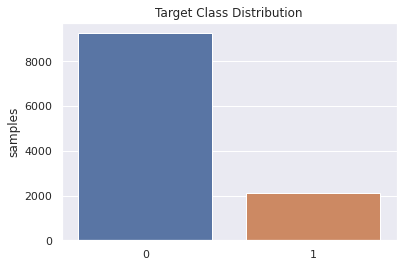

In [ ]:
target_values = tweets_df4["target"].value_counts()
sns.barplot(target_values.index, target_values)
plt.gca().set_ylabel("samples")
plt.title("Target Class Distribution")
plt.show()

In [ ]:
print(target_values)

0    9256
1    2114
Name: target, dtype: int64


Our 'real disaster' class is underrepresented, but it is only about a 1/5 ratio. The 'read disaster' or minority class is our class of interest. We want to know if a real disaster is imminent since we will need to respond according to a real disaster. We ideally want high precision and high recall with the minority class. In this project we will use accuracy as our test metric, but will focus our analysis on improvments to F1-scores for the minority class. 

We have some options in dealing with this class imbalance problem. We could up-sample the minoirty class using SMOTE, but that will not work well with text data. We could down-sample the majority class, but our dataset is already small at just over 11,300 data points. Another option is to change our evalution metric to F1 score. This won't have us overweightting one highly accurate class. 

An option that could work is to augment our data. Data Augmentation is pretty common with NLP tasks. We will try this approach after we have tried without it. That way we have a comparison group and we will see which approach performs best. 

In [ ]:
tweets_df4["keyword"].nunique()

208

In [ ]:
keywords = pd.DataFrame(tweets_df4["keyword"].value_counts()).reset_index()
keywords.columns = ["keyword", "frequency"]
keywords.head(20)

,keyword,frequency
0,body,175
1,emergency,161
2,suicide,137
3,buildings,132
4,mass,131
5,nuclear,127
6,thunderstorm,93
7,flattened,88
8,fire,86
9,stretcher,86


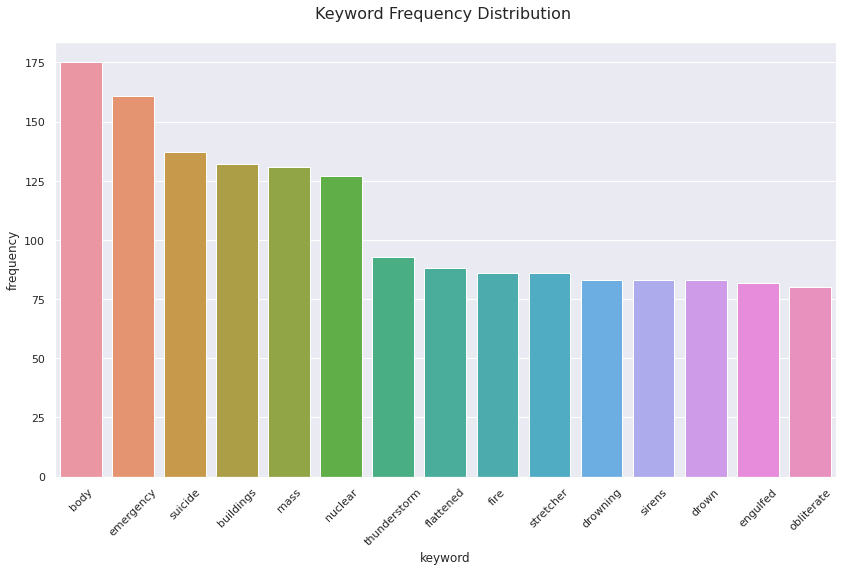

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(data=keywords.head(15), x="keyword", y="frequency")
plt.title("Keyword Frequency Distribution \n", fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [ ]:
def wordcloud(text, colormap="tab10", background_color="white"):
    cloud = WordCloud(
        width=1600,
        height=800,
        collocations=False,
        colormap=colormap,
        background_color=background_color,
    ).generate(" ".join(text))

    plt.figure(figsize=(12, 10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

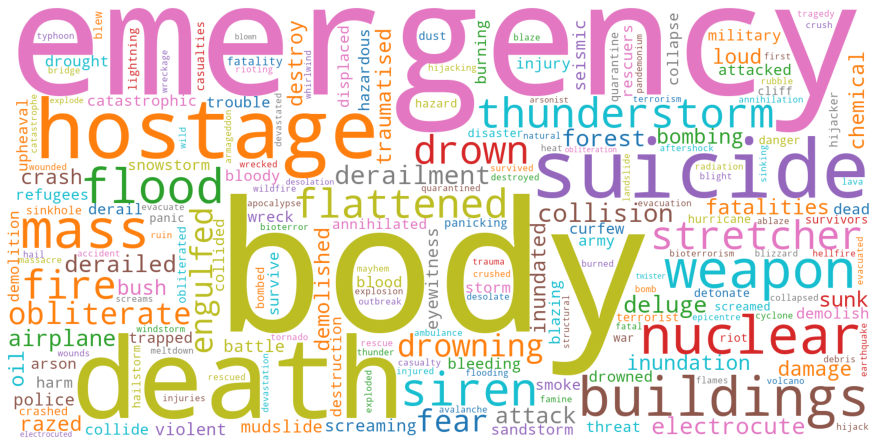

In [ ]:
wordcloud(tweets_df4["keyword"])

## Feature Engineering

We will tokenize, lemmatize, and remove stop words our text data. Then we will train/test split our dataset. 

In [ ]:
def preprocess(docs):
  lemmatizer = WordNetLemmatizer()
  preprocessed = []

  for doc in docs:
    tokenized = word_tokenize(doc)

    cleaned = [lemmatizer.lemmatize(token.lower())
              for token in tokenized
              if token.lower() not in stopwords.words('english')
              if token.isalpha()]
    
    untokenized = ' '.join(cleaned)

    preprocessed.append(untokenized)

  return preprocessed

In [ ]:
# process words in text
preprocessed = preprocess(tweets_df4['text'])
tweets_df4['text'] = preprocessed

In [ ]:
preprocessed[:5]

['communal violence bhainsa telangana stone pelted muslim house house vehicle set',
 'telangana section imposed bhainsa january clash erupted two group january',
 'arsonist set car ablaze dealership',
 'arsonist set car ablaze dealership',
 'lord jesus love brings freedom pardon fill holy spirit set heart ablaze']

In [ ]:
tweets_df4.head()

,keyword,text,target
0,ablaze,communal violence bhainsa telangana stone pelt...,1
1,ablaze,telangana section imposed bhainsa january clas...,1
2,ablaze,arsonist set car ablaze dealership,1
3,ablaze,arsonist set car ablaze dealership,1
4,ablaze,lord jesus love brings freedom pardon fill hol...,0


We split our data here to make it easier to augment the data later. We will also use the stratify parameter so our class imbalance stays consistent between train and test set. It could be even more problematic if our already imbalanced dataset got more imbalanced because of a random train/test split. 

In [ ]:
# define X and y
## splitting on X on df4 instead of df4['text] here will make it easier to augment our data later
X = tweets_df4
y = tweets_df4['target']

# test/train split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
y_train.value_counts()

0    7405
1    1691
Name: target, dtype: int64

In [ ]:
y_test.value_counts()

0    1851
1     423
Name: target, dtype: int64

In [ ]:
# define our X train/test split to the text column only
X_train_text = X_train['text']
X_test_text = X_test['text']

In [ ]:
X_train_text.head()

9056     lot talk away game pool attacker fixture ticke...
1327     karma bad psychosis affect hellelrufai brain p...
10483    million traumatised wildlife million traumatis...
4697      electrocute running screaming hang foot cut neck
1183     gunman open fire protester iran video show blo...
Name: text, dtype: object

In [ ]:
X_test_text.head()

342     common sense twitter first sign apocalypse loo...
557     dsp davinder singh worked jem terrorist money ...
8310    part problem happens absolute sincerity look e...
4872             cash wasted emergency service struggling
3097         walking dead got stranger thing breaking bad
Name: text, dtype: object

## Modeling without Data Augmentation

First we will model without data augmentation. We will also split our non-augment models by balanced class weights. For Logistic Regression, Random Forest and SVC we will have two models - one that where class wieghts are balanced and one where it is not. Gradient Boosting does not have a class weights paramenter, but gradient boosting deals with class imbalance by constructing subsequent iterations in an attempt to correct misclassified values.

We will also tfidf vectorize our text data in the modeling step to prevent a preproccesing issue when we augment our data later. 

In [ ]:
# logistic regression + tdidf
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('logistic',LogisticRegression()),
                      ])
parameters = {'logistic__C': stats.uniform(0.1, 100),
              'logistic__penalty': ['l1', 'l2'],
              'logistic__solver': ['lbfgs', 'liblinear']}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


00 hours, 03 minutes, 37 seconds


In [ ]:
#plot confustion matric helper function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# function that displays a confusion matrix and classifcation report
def confusion_report(model, model_name):
  # define y test pred
  y_test_pred = model.predict(X_test_text)

  # plot model confusion matrix
  confusion = confusion_matrix(y_test, y_test_pred)
  plot_confusion_matrix(cm=confusion, 
                        target_names=['No Disaster','Disaster'],
                        title = f'{model_name.capitalize()} Model Disaster Tweets Confusion Matrix',
                        normalize=False)
  # model classifcation report
  print('\n')
  print('\n')
  print(f'---------------{model_name.capitalize()} Model Classification Report---------------')
  print(classification_report(y_test, y_test_pred))


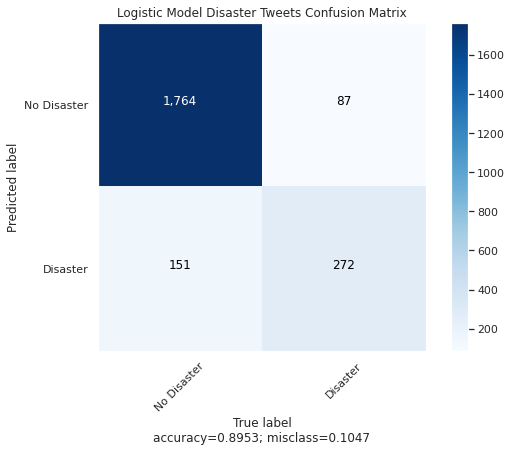





---------------Logistic Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1851
           1       0.76      0.64      0.70       423

    accuracy                           0.90      2274
   macro avg       0.84      0.80      0.82      2274
weighted avg       0.89      0.90      0.89      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Logistic')

In [ ]:
# logistic regression + tdidf + class balance
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('logistic',LogisticRegression(class_weight = 'balanced'))
                  ])
parameters = {'logistic__C': stats.uniform(0.1, 100),
              'logistic__penalty': ['l1', 'l2'],
              'logistic__solver': ['lbfgs', 'liblinear']}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


00 hours, 06 minutes, 32 seconds


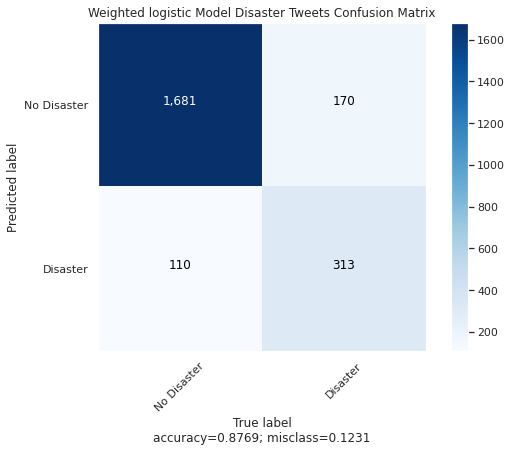





---------------Weighted logistic Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1851
           1       0.65      0.74      0.69       423

    accuracy                           0.88      2274
   macro avg       0.79      0.82      0.81      2274
weighted avg       0.88      0.88      0.88      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Weighted Logistic')

Our class weighted logistic regression model has better minority class recall, but worse precision than the non-weighted model. Both almost indentical minority class F1-scores. 

In [ ]:
# random forest + tdidf
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('rfc',RandomForestClassifier())
                  ])
parameters = {'rfc__n_estimators': stats.randint(4,200),
              'rfc__max_depth': stats.randint(5, 30),
              'rfc__min_samples_split': stats.randint(2, 20),
              'rfc__min_samples_leaf': stats.randint(2, 20)}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min


00 hours, 03 minutes, 39 seconds


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


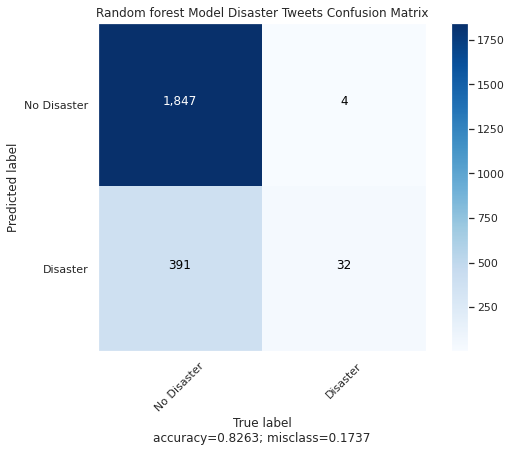





---------------Random forest Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1851
           1       0.89      0.08      0.14       423

    accuracy                           0.83      2274
   macro avg       0.86      0.54      0.52      2274
weighted avg       0.84      0.83      0.76      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Random Forest')

In [ ]:
# random forest + tdidf + class balance
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('rfc',RandomForestClassifier(class_weight = 'balanced'))
                  ])
parameters = {'rfc__n_estimators': stats.randint(4,200),
              'rfc__max_depth': stats.randint(5, 30),
              'rfc__min_samples_split': stats.randint(2, 20),
              'rfc__min_samples_leaf': stats.randint(2, 20)}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


00 hours, 03 minutes, 25 seconds


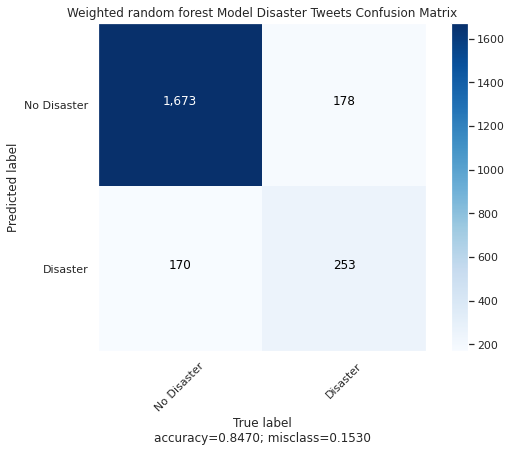





---------------Weighted random forest Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1851
           1       0.59      0.60      0.59       423

    accuracy                           0.85      2274
   macro avg       0.75      0.75      0.75      2274
weighted avg       0.85      0.85      0.85      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Weighted Random Forest')

Our non-weighted random forest model has much higher precision in the minority class, but very poor recall and accuracy scores when compared to our class weighted model. Our weighted random forest model has a much higher minority class F1-score. 

In [ ]:
# svm + tdidf
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('svc',SVC())
                  ])
parameters = {'svc__C': stats.randint(1,100),
              'svc__gamma': stats.uniform(.0001, 1),
              'svc__kernel': ['sigmoid'],
              }

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=50 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 16.1min finished


00 hours, 16 minutes, 09 seconds


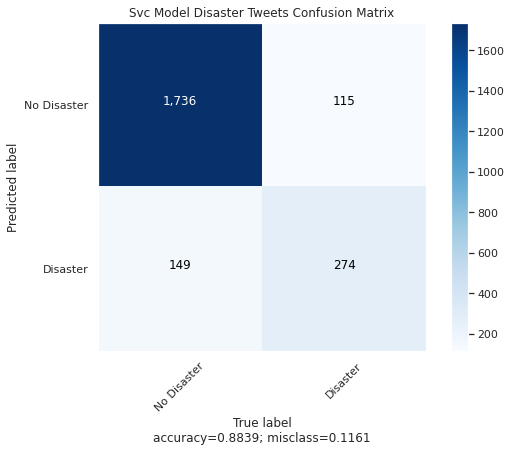





---------------Svc Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1851
           1       0.70      0.65      0.67       423

    accuracy                           0.88      2274
   macro avg       0.81      0.79      0.80      2274
weighted avg       0.88      0.88      0.88      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'SVC')

In [ ]:
# svm + tdidf + class balance
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('svc',SVC(class_weight='balanced'))
                  ])
parameters = {'svc__C': stats.randint(1,100),
              'svc__gamma': stats.uniform(.0001, 1),
              'svc__kernel': ['sigmoid'],
              }

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=50 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 16.8min finished


00 hours, 16 minutes, 54 seconds


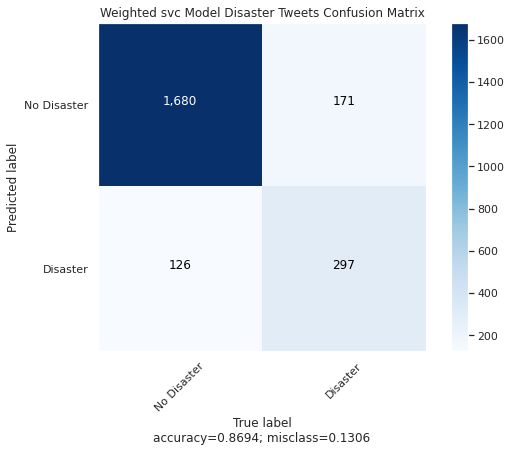





---------------Weighted svc Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1851
           1       0.63      0.70      0.67       423

    accuracy                           0.87      2274
   macro avg       0.78      0.80      0.79      2274
weighted avg       0.88      0.87      0.87      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Weighted SVC')

Minority class precision is better in the non-weighted SVC model, but recall is worse. Minoriy F1-scores are identical for the SVC models. 

So far both logistic regression models have had the highest F1-scores followed by both SVC models. Let's see if gradient boosting can improve on these scores. 

In [ ]:
# gradient boosting + tdidf
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('gbc',GradientBoostingClassifier())
                  ])
parameters = {'gbc__learning_rate': stats.uniform(.001, .3),
              'gbc__n_estimators': stats.randint(10, 1500),
              'gbc__max_depth': stats.randint(2, 15),
              'gbc__n_iter_no_change': [10],
              'gbc__max_features': ['sqrt',.75,1]
              }

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 117.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 140.7min finished


02 hours, 20 minutes, 50 seconds


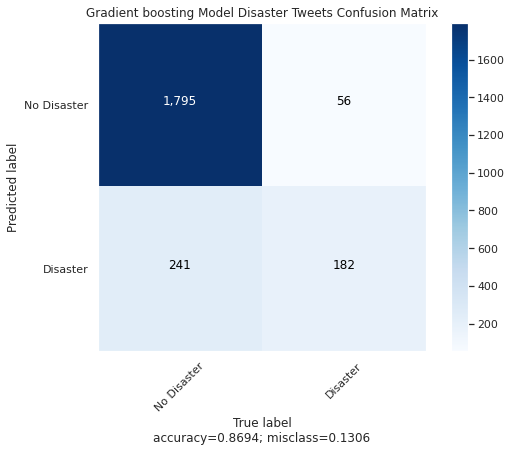





---------------Gradient boosting Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1851
           1       0.76      0.43      0.55       423

    accuracy                           0.87      2274
   macro avg       0.82      0.70      0.74      2274
weighted avg       0.86      0.87      0.85      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'Gradient Boosting')

The gradient boosting model has the 2nd best minority class precision of any model, but some of the worst recall and F1-scores. It appears that both logistic regression models did best with minority class preditions. In particular the non-weighted logistic regression model did the best. it has the 2nd highest precision of any model and the highest F1-score. 

## Data Augmentation
Next we will upsample the minority class by augmenting our dataset with more synthetic examples of the minority class. To accomplish this we will translate a 'real disaster' tweet into German or Russian and then translate it back to English. This allows us to create synthetic data that has context, because you can't just randonly scramble words or characters in a language or the entire statement could become incoherent and meaningless. This back translating technique has been successful in improving F1-scores in text datasets that have class imbalance issues. We will see how useful it is here. 

In [ ]:
# download german transfomer and test naw text converter
# start transformer run time
start_time = time.time() 

text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='transformer.wmt19.en-de',
    to_model_name='transformer.wmt19.de-en')
back_translation_aug.augment(text)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 11946275315/11946275315 [06:42<00:00, 29707252.75B/s]
Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master
100%|██████████| 11958904958/11958904958 [06:33<00:00, 30403090.22B/s]


00 hours, 28 minutes, 21 seconds


In [ ]:
# download russian transformer and test naw text converter
%%capture
# start transformer run time
start_time = time.time() 

text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='transformer.wmt19.en-ru',
    to_model_name='transformer.wmt19.ru-en')
back_translation_aug.augment(text)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

In [ ]:
# print russian to english back translation
print(back_translation_aug.augment(text)) 

A quick brown fox jumped on a lazy dog


In [ ]:
non_disaster_count = tweets_df4['target'].value_counts()[0]
disaster_count = tweets_df4['target'].value_counts()[1]

print(non_disaster_count, disaster_count)

9256 2114


In [ ]:
# create X_train df where target = 1 
disaster_df = X_train.loc[y_train == 1]
#disaster_df.value_counts()
len(disaster_df)

1691

In [ ]:
non_disaster_df = X_train.loc[y_train == 0]
len(non_disaster_df)

7405

In [ ]:
# get counts for each class in X_train
non_disaster_count = len(non_disaster_df)
disaster_count = len(disaster_df)
# calcuate current class imbalance number
non_disaster_count-disaster_count

5714

In [ ]:
# stop num equal the imbalce between the current classes
stop_num = non_disaster_count-disaster_count

In [ ]:
# back translate function to augment text data
def aug_text(df, text_column, stop_num):
    # list for newly augmented data
    aug_data = pd.DataFrame()
    while aug_data.shape[0] < stop_num:
        sample = df.sample()
        for text in sample[text_column]:
            language = [
                ("transformer.wmt19.en-de", "transformer.wmt19.de-en"),
                ("transformer.wmt19.en-ru", "transformer.wmt19.ru-en"),
            ]
            # randomize language selection
            sr = random.choice(language)
            # back translate text
            back_translation_aug = naw.BackTranslationAug(
                from_model_name=f"{sr[0]}", to_model_name=f"{sr[1]}"
            )
            bt_text = back_translation_aug.augment(text)
            sample[text_column] = bt_text
            sample_df = pd.DataFrame(sample) 
            aug_data = aug_data.append(sample_df, ignore_index=True)

    return aug_data

In [ ]:
# start back translate run time
start_time = time.time() 

back_translate_df = aug_text(disaster_df,'text',stop_num=stop_num)
# print back translate runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

06 hours, 59 minutes, 43 seconds


In [ ]:
# apply text augmenation to X_train and y_train
X_train_temp = pd.concat([X_train,back_translate_df],axis=0)
X_train_text = X_train_temp['text']
y_train_temp = back_translate_df['target']
y_train_concat = pd.concat([y_train,y_train_temp],axis=0)
y_train = y_train_concat

In [ ]:
back_translate_df.head(20)

,keyword,text,target
0,evacuate,Expert warns Taal volcano eruption could worse...,1
1,oil,Keystone pipeline leaks gallon of oil second m...,1
2,nuclear,Matte Gurney false nuclear alert shows Canada ...,1
3,damage,Another earthquake struck Puerto Rico in the m...,1
4,sunk,Polish destroyer orp grom sinks Norwegian camp...,1
5,inundation,Flash flood warning remains in effect in highe...,1
6,trapped,hong kong knife attack motorist caught overtur...,1
7,floods,The bypass canal has been nearly dry for two m...,1
8,hazardous,Taal volcano news live dangerous eruption set ...,1
9,stretcher,Undoubtedly one of Clemson's key players will ...,1


In [ ]:
X_train_temp['target'].value_counts()

1    7405
0    7405
Name: target, dtype: int64

In [ ]:
y_train.value_counts()

1    13119
0     7405
Name: target, dtype: int64

In [ ]:
X_train.shape, y_train.shape

((9096, 3), (20524,))

In [ ]:
X_train_text.shape, y_train.shape

((14810,), (20524,))

In [ ]:
# accidently reran cells above
## remove the double append of y train
y_train = y_train[:-5714]
X_train_text.shape, y_train.shape

((14810,), (14810,))

## Data Augmented Modeling

Now we will model our data using the same 4 models used previously (Logistic Regression, Random Forest, SVC, Gradient Boosting), but this time with our classes balanced with synthetic data for the minority class. Let's see how it turns out. 

In [ ]:
#logistic regression + tdidf + back translate
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('logistic',LogisticRegression())
                  ])
parameters = {'logistic__C': stats.uniform(0.1, 100),
              'logistic__penalty': ['l1', 'l2'],
              'logistic__solver': ['lbfgs', 'liblinear']}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


00 hours, 02 minutes, 36 seconds


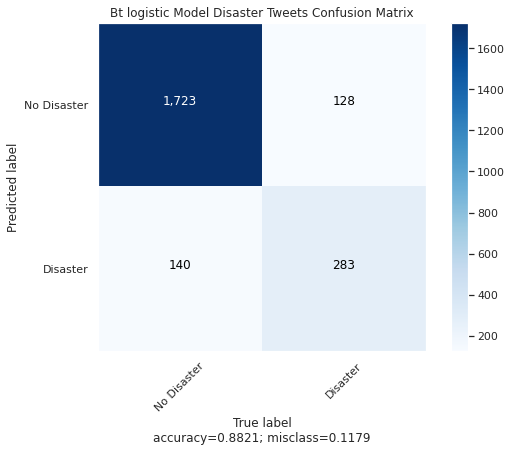





---------------Bt logistic Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1851
           1       0.69      0.67      0.68       423

    accuracy                           0.88      2274
   macro avg       0.81      0.80      0.80      2274
weighted avg       0.88      0.88      0.88      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'BT Logistic')

We see similiar results for the minoirty class that we saw with the two previous logistic regression models. The F1-score is .02 and .01 worse than the other two models. 

In [ ]:
# random forest + tdidf + back translate
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('rfc',RandomForestClassifier())
                    ])
parameters = {'rfc__n_estimators': stats.randint(4,200),
              'rfc__max_depth': stats.randint(5, 30),
              'rfc__min_samples_split': stats.randint(2, 20),
              'rfc__min_samples_leaf': stats.randint(2, 20)}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.2min finished


00 hours, 05 minutes, 14 seconds


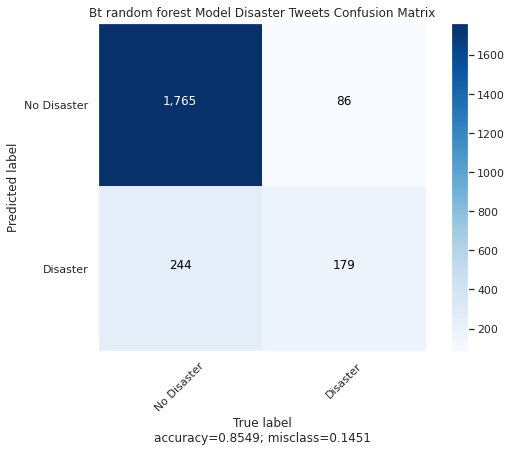





---------------Bt random forest Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1851
           1       0.68      0.42      0.52       423

    accuracy                           0.85      2274
   macro avg       0.78      0.69      0.72      2274
weighted avg       0.84      0.85      0.84      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'BT Random Forest')

The back translated random forest model still performs worse than the class weighted model, but it does outperform the non-class weighted random forest model. F1-score is slightly worse for this model compared to the random forest class weighted model. 

In [ ]:
# svm + tdidf + back translate
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('svc',SVC())
                  ])
parameters = {'svc__C': stats.randint(1,100),
              'svc__gamma': stats.uniform(.0001, 1),
              'svc__kernel': ['sigmoid'],
              }

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=50 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 40.9min finished


00 hours, 41 minutes, 16 seconds


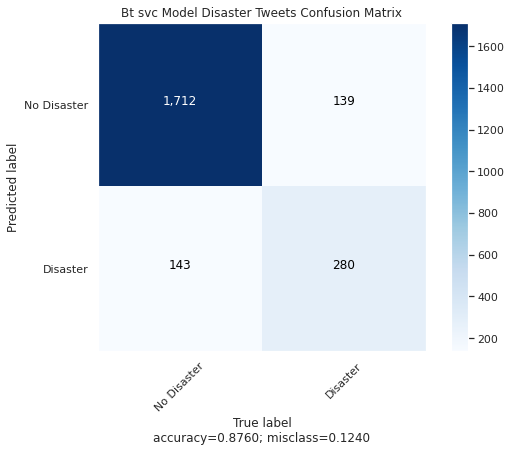





---------------Bt svc Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1851
           1       0.67      0.66      0.67       423

    accuracy                           0.88      2274
   macro avg       0.80      0.79      0.79      2274
weighted avg       0.88      0.88      0.88      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'BT SVC')

All SVC models had the same F1-score and performed about the same on precision and recall. This back translated model had the 2nd best precision and recall scores of the three SVC models. 

In [ ]:
# gradient boosting + tdidf + back translate
# start model run time
start_time = time.time() 

pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('gbc',GradientBoostingClassifier())
                  ])
parameters = {'gbc__learning_rate': stats.uniform(.001, .3),
              'gbc__n_estimators': stats.randint(10, 1500),
              'gbc__max_depth': stats.randint(2, 15),
              'gbc__n_iter_no_change': [10],
              'gbc__max_features': ['sqrt',.75,1]
              }

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100 ,verbose=True)

model.fit(X_train_text, y_train)
# print model runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 212.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 468.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 499.2min finished


08 hours, 19 minutes, 25 seconds


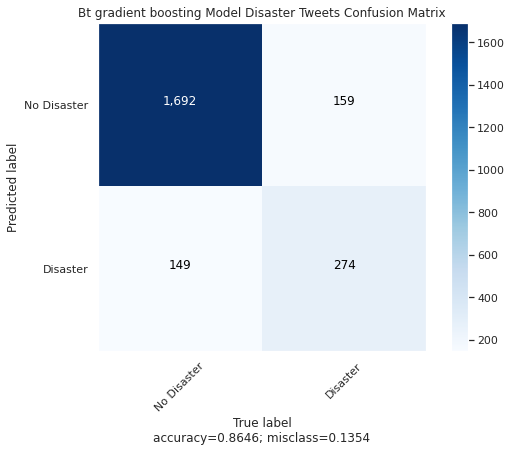





---------------Bt gradient boosting Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1851
           1       0.63      0.65      0.64       423

    accuracy                           0.86      2274
   macro avg       0.78      0.78      0.78      2274
weighted avg       0.87      0.86      0.87      2274



In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'BT Gradient Boosting')

The back translated gradient boosting model perfromed better in all categories than its counterpart. We see and 0.05 improvement in F1-score. 

## Conclusion

We did not see the big boost in model performance we expected by injecting augmented data into our model. We saw similiar performances among simliar model types, which the exception of a signficant improvement in the gradient boosting model with data augmentation. Overall, a non-augmented and non-class weighted model was best- logistic regression. It had the highest F1-score and the 2nd highest precision of any model. 

Perhaps this dataset was too small to see significant model improvement with augmented data. Perhaps other text preprocessing techinques would improve results. Another issue could have been using accuracy as the test metric instead of F1-score. These are just a few possible ways to improve our model performance in the future. 